In [3]:
import pandas as pd
import numpy as np
import os

# Первичный анализ.

Прочитаем csv файлы.

In [4]:
train = pd.read_csv('train.csv')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
sample_submission = pd.read_csv('sample_submission.csv')
severity_type = pd.read_csv('severity_type.csv')
test = pd.read_csv('test.csv')

Проанализируем таблицы.

In [4]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [5]:
len(train['id']) == len(train['id'].drop_duplicates())

True

Дубликатов нету.

In [6]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [7]:
np.mean(event_type.groupby('id')['event_type'].count())

1.6801423027166882

На каждый id в среднем 1.7 ~ 2 типа события. Думаю надо делать dummy для каждого события и цеплять к основной таблице. Сколько всего событий итересно?

In [8]:
len(event_type.groupby('event_type')['id'].count())

53

53 типа события. Ладно, окей. Теперь log_feature.

In [10]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [11]:
len(log_feature.groupby('log_feature')['id'].count())

386

Ого, столько фич! Наверное нужно будет делать PCA.

In [12]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [13]:
resource_type.groupby('resource_type').count()

,id
resource_type,
resource_type 1,58
resource_type 10,73
resource_type 2,8918
resource_type 3,145
resource_type 4,330
resource_type 5,14
resource_type 6,582
resource_type 7,498
resource_type 8,10268


In [14]:
len(resource_type['id']) == len(resource_type['id'].drop_duplicates())

False

Типов источника всего 10. Теперь Severity_type.

In [15]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [16]:
severity_type.groupby('severity_type').count()

,id
severity_type,
severity_type 1,8728
severity_type 2,8737
severity_type 3,8
severity_type 4,1014
severity_type 5,65


И вот образец того, что должно получиться на выходе.

In [17]:
len(severity_type['id']) == len(severity_type['id'].drop_duplicates())

True

In [18]:
len(severity_type)

18552

In [19]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


Резюмирую и намечу план действий. И так:

1. В train храняться сведения о сбое - где он произошел и какова его тяжесть (0 - нет сбоя, 1 - средний сбой, 2 - сильный сбой). Задача заключается в том, чтобы предсказывать тяжесть сбоя по имеющимся данным. Каждая строка - это точка во временени, о которой нам известны некоторые данные и был ли там сбой и какова его тяжесть.
2. В табличке event_type храниться информацию о том, какие события происходили в точку времени. Связывается с основной таблицей по id (как и все остальные).
3. log_feature - это основноый массив переменных, значения которых так же связаны с точкой во времение (основной таблицей).
4. В resource_type храниться сведения об источнике. Из описания не очень понятно что-то. Будем считать ее одной переменной.
5. severity_type - тип сбоя. В описании так же написано, что здесь тут храняться и типы предупреждений.
6. sample_submission - пример в каком формате загружать на Kaggle.

И так что нужно сделать? Предсказать тяжесть ошибки. Значит это будет многоклассовый классификатор, буду пробывать логистическую регрессию, лес, бустинг, svm. Основной мерой качества будет roc_auc - никакой матрицы цен ошибок не предоставляется. План действий:

1. Собрать данные в одну таблицу для тренировочной и тестовой выборки.
2. Произвести отбор переменных: посмотреть на корреляции, коэффициенты в регрессии, важность признаков в лесе и в svm.
3. Попробывать понизить размерность с помощью PCA.
4. Обучить набор моделей с кросс-валидацией по kfold и посмотреть какой будет roc_auc
5. Выбрать лучшую модель, загрузить на Kaggle и посмотреть какие у меня успехи; почитать форум - что делает народ.
6. Оттюнить параметры модели с помощью grid_search.
7. Еще раз загрузить на Kaggle.

# Обработка данных. 

Для катеториальных признаков будем создавать колонки на каждую категорию с 0 либо 1, а для числовых - колонку для каждой переменной со значением.

In [496]:
df = train.copy() # создадим копию фрейма + потом можно функцию замутить.

Преобразуем локацию. (потом выяснилось, что в тестовом сете есть локации, которых нету в тренировочных. Следовательно я не использую эту переменную. Хотя наверное можно объединить два сета и сделать так, чтобы модель знала все возможные локации).

In [497]:
location = df[['id','location']]
df.drop(['location'],axis=1,inplace=True)
location_dummies = pd.get_dummies(location).groupby('id').sum()
df = df.merge(location_dummies.reset_index(),
            how='left',on='id')

Добавляем события.

In [22]:
event_dummies = pd.get_dummies(event_type).groupby('id').sum()
df = df.merge(event_dummies.reset_index(),
            how='left',on='id')

Добавляем переменные.

In [23]:
features = log_feature.pivot_table('volume','id','log_feature','sum')
df = df.merge(features.reset_index(),
            how='left',on='id')

In [24]:
len(df.columns)

1370

Уже какой-то трэш. Наверное лучше будет хранить все это в разреженных матрицах. Присоединит тип источника

In [25]:
resource_dummies = pd.get_dummies(resource_type).groupby('id').sum()
df = df.merge(resource_dummies.reset_index(),
            how='left',on='id')

In [26]:
len(df.columns)

1380

Ну и тип ошибки остался

In [27]:
severity_dummies = pd.get_dummies(severity_type).groupby('id').sum()
df = df.merge(severity_dummies.reset_index(),
            how='left',on='id')

In [28]:
len(df.columns)

1385

In [79]:
df.shape

(7381, 1384)

Мощная получилась табличка!) Теперь, чтобы все это не делать для тестовой выборки - быстренько скопипастим все это в функцию.

In [106]:
def join_data(data):
    df = data.copy()
    
    #location = df[['id','location']]
    #df.drop(['location'],axis=1,inplace=True)
    #location_dummies = pd.get_dummies(location).groupby('id').sum()
    #df = df.merge(location_dummies.reset_index(),
     #       how='left',on='id')
        
    df.drop('location',axis=1,inplace=True)
    
    event_dummies = pd.get_dummies(event_type).groupby('id').sum()
    df = df.merge(event_dummies.reset_index(),
            how='left',on='id')
    
    features = log_feature.pivot_table('volume','id','log_feature','sum')
    df = df.merge(features.reset_index(),
            how='left',on='id')
    
    resource_dummies = pd.get_dummies(resource_type).groupby('id').sum()
    df = df.merge(resource_dummies.reset_index(),
            how='left',on='id')
    
    severity_dummies = pd.get_dummies(severity_type).groupby('id').sum()
    df = df.merge(severity_dummies.reset_index(),
            how='left',on='id')
    
    return df

In [107]:
join_data(test).shape

(11171, 455)

Все верно - в тестовых данных нету колонки со степенью тяжести ошибки. Ее надо предсказать). Этот дата сет мы отложим до самого финала. Ну тоже, давате уже что-нибудь обучим.

In [108]:
df = join_data(train)
df.drop('id',axis=1,inplace=True) # id нам больше не нужен

Передвинем целевую переменную в начало фрейма.

In [109]:
cols = list(df.columns)
cols.insert(0,cols.pop(cols.index('fault_severity')))
df = df.ix[:,cols]

Удалим nan

In [110]:
df.fillna(0,inplace=True)

In [111]:
X, y = df.ix[:,1:], df.ix[:,0]

In [112]:
from sklearn.cross_validation import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [113]:
import matplotlib.pyplot as ptl
%matplotlib inline

In [114]:
cv = KFold(len(y),5,shuffle=True,random_state=1)

Проверим сначала лес.

In [115]:
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=250), X, y, cv=cv)

In [117]:
accuracy_score(y,y_pred)

0.7381113670234386

In [119]:
print classification_report(y,y_pred)

             precision    recall  f1-score   support

          0       0.80      0.85      0.82      4784
          1       0.58      0.51      0.54      1871
          2       0.63      0.63      0.63       726

avg / total       0.73      0.74      0.73      7381



In [46]:
y_pred2 = cross_val_predict(GradientBoostingClassifier(n_estimators=250), X, y, cv=cv)

print classification_report(y,y_pred2)

Короче -

1. нужно построить roc_auc,
2. Оттюнить модель (скорее всего лес) по гипер-параметрам.
3. Попробывать PCA
4. Найти способ менять порог в процессе кросс-валидации.

In [54]:
from sklearn.decomposition import PCA

In [120]:
decomp = PCA(100)

In [121]:
x_dec = decomp.fit_transform(X)

In [122]:
sum(decomp.explained_variance_ratio_)

0.99972846897764656

In [123]:
y_pred3_boost = cross_val_predict(GradientBoostingClassifier(n_estimators=250), x_dec, y, cv=cv)

In [124]:
print classification_report(y,y_pred3_boost)

             precision    recall  f1-score   support

          0       0.81      0.86      0.83      4784
          1       0.61      0.50      0.55      1871
          2       0.63      0.67      0.65       726

avg / total       0.74      0.75      0.74      7381



In [59]:
y_pred3 = cross_val_predict(RandomForestClassifier(n_estimators=100, criterion='entropy'), x_dec, y, cv=cv)

In [60]:
print classification_report(y,y_pred3)

             precision    recall  f1-score   support

          0       0.81      0.85      0.83      4784
          1       0.61      0.53      0.57      1871
          2       0.62      0.62      0.62       726

avg / total       0.74      0.75      0.74      7381



In [101]:
from sklearn.metrics import accuracy_score

In [62]:
accuracy_score(y,y_pred3)

0.74759517680531096

In [125]:
clf = GradientBoostingClassifier(n_estimators=250)

clf.fit(x_dec,y)

In [127]:
x_sub = join_data(test)
x_sub.fillna(0, inplace=True)
x_sub.drop('id',axis=1,inplace=True)

x_sub = decomp.transform(x_sub)

clf.predict(x_sub)

submission = test.copy()
submission['class'] = clf.predict(x_sub)

submission.drop('location',axis=1,inplace=True)

submission = pd.concat([submission['id'],pd.get_dummies(submission['class'],prefix='predict')],axis=1)

In [156]:
def convert(x):
    try:
        return x.astype(int)
    except:
        return x

In [158]:
submission = submission.apply(convert)

submission.to_csv('submission1.csv',index=False)

И так я сделал первый submission и оказался на 722 месте из 835). Теперь надо попробовать оттюнить бустинг, чтобы улучшить результат. Буду делать это с помощью Gridsearch. Ну и форум почитаю.)

- The frequency each categorical feature class occurs, i.e., how many times a specific location or event_type occurs
- Convert a categorical into an integer, e.g., severity_type -> [1,5] or location as its number.
- Create products of existing features, e.g.,log_feature volume * severity as an integer.

Вот материалы:

http://www.slideshare.net/DataRobot/gradient-boosted-regression-trees-in-scikitlearn
http://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions (тут есть рекомендованные параметры для бустинга)
https://www.youtube.com/watch?v=LgLcfZjNF44&feature=youtu.be


Решил делать следующее:
- перевести категорийные переменные в численные, путем подсчета частот каждой категории. Таким образом я смогу использовать локайшн. Если еще идея использовать вместо подсчета просто номер категории). Надо затестить.
- обучить бустинг с грид-сёрчем.

In [300]:
location_count = train.groupby('location')['id'].count().reset_index()

location_count.rename(columns={'id':'loc_count'},inplace=True)

df = train.copy()

df = df.merge(location_count,how='left',on='location')

df.drop('location',axis=1,inplace=True)
df.head()

Категорийные переменные, которые повторяются можно перевести таким же образом, только присваивая каждому объекту среднееарифметическое от частот каждой из категорий.

In [305]:
event_count = event_type.groupby('event_type').count().reset_index()

event_count.rename(columns={'id':'event_count'},inplace=True)

event_count = event_type.merge(event_count,how='left',on='event_type')[['id','event_count']]

event_count = event_count.groupby('id').mean()

In [309]:
event_count.head()

,event_count
id,
1,4235
2,6271
3,7888
4,69
5,6271


Фичи трогать не буду. А вот тип ресурса и тип ошибки перекодирую в нумерик просто как номер типа, для повторяющихся возьму среднее.

In [310]:
import re

In [311]:
f = lambda x: int(re.findall(r'\d+',x)[0])

resource_num = resource_type.copy()

resource_num['res_num'] = resource_type['resource_type'].apply(f)

resource_num.drop('resource_type',axis=1,inplace=True)

resource_num = resource_num.groupby('id').mean()

In [316]:
resource_num.head()

,res_num
id,
1,7
2,2
3,8
4,2
5,2


Теперь перекодируем тип ошибки

In [317]:
severity_num = severity_type.copy()

severity_num['sev_num'] = severity_type['severity_type'].apply(f)

severity_num = severity_num.groupby('id')['sev_num'].mean().to_frame()

In [320]:
severity_num.head()

,sev_num
id,
1,1
2,2
3,1
4,4
5,2


Ну а теперь нужно все это присоединить к главной таблице

In [321]:
df = df.merge(event_count.reset_index(),
            how='left',on='id')


df = df.merge(resource_num.reset_index(),
            how='left',on='id')


df = df.merge(severity_num.reset_index(),
            how='left',on='id')

features = log_feature.pivot_table('volume','id','log_feature','sum')
df = df.merge(features.reset_index(),
            how='left',on='id')

In [329]:
df.fillna(0,inplace=True)

ну и теперь надо все это в функцию обернуть.

In [362]:
def join_data2(x):
    df = x.copy()
    # location
    location_count = train.groupby('location')['id'].count().reset_index()
    location_count.rename(columns={'id':'loc_count'},inplace=True)
    df = df.merge(location_count,how='left',on='location')
    df.drop('location',axis=1,inplace=True)
    
    # events
    event_count = event_type.groupby('event_type').count().reset_index()
    event_count.rename(columns={'id':'event_count'},inplace=True)
    event_count = event_type.merge(event_count,how='left',on='event_type')[['id','event_count']]
    event_count = event_count.groupby('id').mean()
    
    # resource
    f = lambda x: int(re.findall(r'\d+',x)[0])
    resource_num = resource_type.copy()
    resource_num['res_num'] = resource_type['resource_type'].apply(f)
    resource_num.drop('resource_type',axis=1,inplace=True)
    resource_num = resource_num.groupby('id').mean()
    
    # severity
    severity_num = severity_type.copy()
    severity_num['sev_num'] = severity_type['severity_type'].apply(f)
    severity_num = severity_num.groupby('id')['sev_num'].mean().to_frame()
    
    # features
    features = log_feature.pivot_table('volume','id','log_feature','sum')
    
    # joins
    df = df.merge(event_count.reset_index(),
            how='left',on='id')
    df = df.merge(resource_num.reset_index(),
            how='left',on='id')
    df = df.merge(severity_num.reset_index(),
            how='left',on='id')
    df = df.merge(features.reset_index(),
            how='left',on='id')
    
    df.fillna(0,inplace=True)
    
    cols = list(df.columns)
    try:
        cols.insert(0,cols.pop(cols.index('fault_severity')))
    except:
        pass
    df = df.ix[:,cols]
    
    return df

In [367]:
df = join_data2(train)

df.drop('id',axis=1,inplace=True)

X, y = df.ix[:,1:], df.ix[:,0]

In [371]:
y_pred = cross_val_predict(GradientBoostingClassifier(n_estimators=1000), X, y, cv=cv)

In [351]:
cross_val_score(GradientBoostingClassifier(n_estimators=50), X, y, cv=cv,scoring='log_loss')

array([-0.58561928, -0.59391373, -0.59449703, -0.57581145, -0.57435119])

In [350]:
set(y_pred)

{0, 1, 2}

In [372]:
print classification_report(y,y_pred)

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      4784
          1       0.65      0.54      0.59      1871
          2       0.62      0.69      0.65       726

avg / total       0.76      0.76      0.76      7381



In [373]:
accuracy_score(y,y_pred)

0.76371765343449394

Еще есть мысль создать k-means кластеры на основе категориальных переменных. Т.е. :
1. создать dummies для events, resource и severity
2. k-meansом побить их на кластеры
3. в моделе использовать переменную кластера.

In [374]:
decomp2 = PCA(100)

In [375]:
x_dec = decomp2.fit_transform(X)

In [376]:
sum(decomp2.explained_variance_ratio_)

0.99999989403094747

In [377]:
y_pred = cross_val_predict(GradientBoostingClassifier(n_estimators=1000), x_dec, y, cv=cv,n_jobs=-1)

In [378]:
print classification_report(y,y_pred)

             precision    recall  f1-score   support

          0       0.81      0.86      0.83      4784
          1       0.60      0.52      0.56      1871
          2       0.64      0.61      0.62       726

avg / total       0.74      0.75      0.74      7381



In [379]:
clf = GradientBoostingClassifier(n_estimators=1000)

In [380]:
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [381]:
x_sub = join_data2(test)
x_sub.drop('id',axis=1,inplace=True)

In [382]:
clf.predict(x_sub)

submission = test.copy()
submission['class'] = clf.predict(x_sub)

submission.drop('location',axis=1,inplace=True)

submission = pd.concat([submission['id'],pd.get_dummies(submission['class'],prefix='predict')],axis=1)
submission = submission.apply(convert)

submission.to_csv('submission1.csv',index=False)

715 место. You improved on your best score by 0.87161.

In [383]:
y_pred2 = cross_val_predict(RandomForestClassifier(n_estimators=200, criterion='entropy'), x_dec, y, cv=cv)

Надо всетаки решить какое кол-во деревьев использовать.

In [389]:
import matplotlib.pyplot as plt
%matplotlib inline

In [403]:
np.arange(100,1100, 100)

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

In [405]:
n_vals = np.arange(100,1100, 100)
quality_by_n = [
    cross_val_score(GradientBoostingClassifier(n_estimators=n), X, y, cv=cv,scoring='f1_macro').mean()
    for n in n_vals
]

min_qual=  0.669555806149
best_n=  100


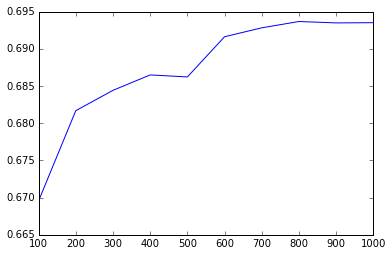

In [406]:
plt.plot(n_vals, quality_by_n)
print 'min_qual= ',min(quality_by_n)
print 'best_n= ',n_vals[np.argmin(quality_by_n)]

1. Надо уменьшить кол-во переменных - поставлю определенный порог на feature_importance
2. И замучу грид-серч.
3. Еще можно перекодироваь локацию просто как цифру, а не как каунт.

In [407]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, make_scorer 
scorer = make_scorer(log_loss, greater_is_better=0, needs_proba=1)

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1] 
              }

est = GradientBoostingClassifier(n_estimators=800)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring=scorer, n_jobs=-1).fit(X, y)

# best hyperparameter setting
gs_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 1.0,
 'min_samples_leaf': 3}

In [421]:
gs_cv.grid_scores_[0][1]

0.58907304344676181

In [424]:
m_list = [i[1] for i in gs_cv.grid_scores_]

m_list[np.argmin(m_list)]

np.argmin(m_list)

In [427]:
gs_cv.grid_scores_[64]

mean: 0.54116, std: 0.01509, params: {'max_features': 0.3, 'learning_rate': 0.02, 'max_depth': 6, 'min_samples_leaf': 3}

In [429]:
clf = GradientBoostingClassifier(n_estimators=1000,max_features=0.3,learning_rate=0.02,max_depth=6,min_samples_leaf=3)

In [430]:
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.02, loss='deviance',
              max_depth=6, max_features=0.3, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [431]:
submission = test.copy()
submission['class'] = clf.predict(x_sub)

submission.drop('location',axis=1,inplace=True)

submission = pd.concat([submission['id'],pd.get_dummies(submission['class'],prefix='predict')],axis=1)
submission = submission.apply(convert)

submission.to_csv('submission3.csv',index=False)

Совсем небольшое улучшение - похоже я делаю что-то нето((. Попробую перекодировать локатион просто в номер локации.

# Удачный submission!

In [433]:
def join_data3(x):
    df = x.copy()
    f = lambda x: int(re.findall(r'\d+',x)[0])
    
    # location
    df['loc_num'] = df['location'].apply(f)
    df.drop('location',axis=1,inplace=True)
    
    # events
    event_count = event_type.groupby('event_type').count().reset_index()
    event_count.rename(columns={'id':'event_count'},inplace=True)
    event_count = event_type.merge(event_count,how='left',on='event_type')[['id','event_count']]
    event_count = event_count.groupby('id').mean()
    
    # resource
    resource_num = resource_type.copy()
    resource_num['res_num'] = resource_type['resource_type'].apply(f)
    resource_num.drop('resource_type',axis=1,inplace=True)
    resource_num = resource_num.groupby('id').mean()
    
    # severity
    severity_num = severity_type.copy()
    severity_num['sev_num'] = severity_type['severity_type'].apply(f)
    severity_num = severity_num.groupby('id')['sev_num'].mean().to_frame()
    
    # features
    features = log_feature.pivot_table('volume','id','log_feature','sum')
    
    # joins
    df = df.merge(event_count.reset_index(),
            how='left',on='id')
    df = df.merge(resource_num.reset_index(),
            how='left',on='id')
    df = df.merge(severity_num.reset_index(),
            how='left',on='id')
    df = df.merge(features.reset_index(),
            how='left',on='id')
    
    df.fillna(0,inplace=True)
    
    cols = list(df.columns)
    try:
        cols.insert(0,cols.pop(cols.index('fault_severity')))
    except:
        pass
    df = df.ix[:,cols]
    
    return df

In [453]:
important_cols = [col for imp, col in zip(clf.feature_importances_,X.columns) if imp > 0.005]

In [455]:
important_cols = ['loc_num'] + important_cols[1:]

In [457]:
df = join_data3(train)
df.drop('id',axis=1,inplace=True)
X, y = df.ix[:,1:], df.ix[:,0]

In [460]:
X = X[important_cols]

In [462]:
scorer = make_scorer(log_loss, greater_is_better=0, needs_proba=1)

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1] 
              }

est = GradientBoostingClassifier(n_estimators=1000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, scoring=scorer, n_jobs=-1).fit(X, y)

# best hyperparameter setting
gs_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': 0.3,
 'min_samples_leaf': 3}

In [484]:
clf = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.01,max_depth=6,max_features=0.3,min_samples_leaf=3)

In [485]:
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features=0.3, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [486]:
x_sub = join_data3(test)

In [487]:
x_sub = x_sub[important_cols]

In [492]:
submission = test.copy()
submission.drop('location',axis=1,inplace=True)
submission = pd.concat([submission['id'],
                       pd.DataFrame(clf.predict_proba(x_sub))],axis=1)
submission.columns = ['id','predict_0','predict_1','predict_2']
submission.to_csv('submission6.csv',index=False)

312 место!!!

In [498]:
df = join_data3(train)
df.drop('id',axis=1,inplace=True)
X, y = df.ix[:,1:], df.ix[:,0]

In [499]:
clf = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.01,max_depth=6,max_features=0.3,min_samples_leaf=3)
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features=0.3, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [502]:
x_sub = join_data3(test)
x_sub.drop('id',axis=1,inplace=True)

In [503]:
submission = test.copy()
submission.drop('location',axis=1,inplace=True)
submission = pd.concat([submission['id'],
                       pd.DataFrame(clf.predict_proba(x_sub))],axis=1)
submission.columns = ['id','predict_0','predict_1','predict_2']
submission.to_csv('submission7.csv',index=False)

284 место.

In [507]:
cros_val = cross_val_score(clf, X, y, cv=cv,scoring='log_loss')

In [509]:
cros_val.mean()

-0.52583489196691457

In [510]:
df = join_data2(train)
df.drop('id',axis=1,inplace=True)
X, y = df.ix[:,1:], df.ix[:,0]

In [511]:
clf = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.01,max_depth=6,max_features=0.3,min_samples_leaf=3)
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features=0.3, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [512]:
cros_val = cross_val_score(clf, X, y, cv=cv,scoring='log_loss',n_jobs=-1)

In [513]:
cros_val.mean()

-0.53969023927898252

Сделать events не как каунт, а как номре события. Посмотреть что будет.

In [5]:
import re

In [10]:
def join_data4(x):
    df = x.copy()
    f = lambda x: int(re.findall(r'\d+',x)[0])
    
    # location
    df['loc_num'] = df['location'].apply(f)
    df.drop('location',axis=1,inplace=True)
       
    # events
    events_num = event_type.copy()
    events_num['eve_num'] = events_num['event_type'].apply(f)
    events_num.drop('event_type',axis=1,inplace=True)
    events_num = events_num.groupby('id').mean()
    
    # resource
    resource_num = resource_type.copy()
    resource_num['res_num'] = resource_type['resource_type'].apply(f)
    resource_num.drop('resource_type',axis=1,inplace=True)
    resource_num = resource_num.groupby('id').mean()
    
    # severity
    severity_num = severity_type.copy()
    severity_num['sev_num'] = severity_type['severity_type'].apply(f)
    severity_num = severity_num.groupby('id')['sev_num'].mean().to_frame()
    
    # features
    features = log_feature.pivot_table('volume','id','log_feature','sum')
    
    # joins
    df = df.merge(events_num.reset_index(),
            how='left',on='id')
    df = df.merge(resource_num.reset_index(),
            how='left',on='id')
    df = df.merge(severity_num.reset_index(),
            how='left',on='id')
    df = df.merge(features.reset_index(),
            how='left',on='id')
    
    df.fillna(0,inplace=True)
    
    cols = list(df.columns)
    try:
        cols.insert(0,cols.pop(cols.index('fault_severity')))
    except:
        pass
    df = df.ix[:,cols]
    
    return df

In [11]:
df = join_data4(train)
df.drop('id',axis=1,inplace=True)
X, y = df.ix[:,1:], df.ix[:,0]

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
clf = GradientBoostingClassifier(n_estimators=1000,
                                 learning_rate=0.01,
                                 max_depth=6,
                                 max_features=0.3,
                                 min_samples_leaf=3,
                                random_state=0)
clf.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features=0.3, max_leaf_nodes=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=0, subsample=1.0, verbose=0, warm_start=False)

In [17]:
from sklearn.cross_validation import cross_val_score, KFold

In [18]:
cv = KFold(len(y),5,shuffle=True,random_state=0)

In [19]:
cros_val = cross_val_score(clf, X, y, cv=cv,scoring='log_loss')

In [21]:
cros_val.mean()

-0.52612176469510996

Не лучше последнего варианта